# Developing Merge Utilities

## Script Outline

1. **Methdology**

2. **Setup**: Change the intput dataset under "Load data"

3. **Development section**: For developing parts of the final funciton and troubleshooting.

4. **Final Script**: You can skip to this section to run the final function.

5. **Code Sandbox**: Contains scraps of code that may be useful for future development


## TODOS

- Decide on whether we should use "reduce" from "functools" to combine the susbets, or use repeated merges. The second option involves more code, but the first requires an additional module to be used. Unclear which is computatinoally more intensive.


- If the variable is flagged by _eraqc it should be ignored prior to standardization. So for example if precip at :01 is flagged, but precip at :06 is not, the obs at :06 is the one kept etc. We potentially might need to think on if there are qaqc flags that "are okay to keep" and one's that are not.


- Could, in the future, make a library and use a custom resampler on the entire dataset, rather than splitting it inter subsets and performing resampling separately on each (as is done currently)

- address the following warning: 


        SettingWithCopyWarning: 
        A value is trying to be set on a copy of a slice from a DataFrame.
        Try using .loc[row_indexer,col_indexer] = value instead



## Methodology

We break the input dataset into four subsets and then perform resampling on each one between combining them into a single result.


**1. constant variables**


<ins>Includes</ins>: columns like elevation and station name, which stay the same through time AND time variables that are the same within each hour


<ins>Method</ins>: Take the first value to "replace" in the new time stamp. Use "first()" resampler. Only the "time" column will be modified, to be the top of the hour. All others (day, month, year, date) are constant within each hour. Use "first()" resampler.



**2. QA/QC flags**


<ins>Method</ins>: start off with treating them like strings, and concatenanting, with a comma


<ins>Notes</ins>: There's an exception here: if the variable is flagged by _eraqc it should be ignored prior to standardization. So for example if precip at :01 is flagged, but precip at :06 is not, the obs at :06 is the one kept etc. We potentially might need to think on if there are qaqc flags that "are okay to keep" and one's that are not.


**3. summed variables**

<ins>Includes</ins>: variables where standard is to sum across the hour
- precipitation
- solar radiation

<ins>Method</ins>: summed within each hour (using ".sum() resampler"). 


**4. instantaneous variables**

<ins>Includes</ins>: variables where standard is to take one instantaneous value, find observation closest to top of the hour
- temperature
- dewpoint
- wind speed
- direction
- relative humidity
- air pressure

<ins>Method</ins>: summed within each hour (using ".first() resampler"). 

## Setup

In [50]:
#TODO: could use this as an alternative to multiple merges, for combining the subsets into the final output dataframe
from functools import reduce

import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import scipy.stats as stats

import s3fs
import tempfile # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Warning is raised when creating Point object from coords. Can't figure out why. 

In [51]:
## Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client('s3') # for lower-level processes

## Set relative paths to other folders and objects in repository.
bucket_name = "wecc-historical-wx"
wecc_terr = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"

In [52]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary 
temp_dir = "./tmp"
if not os.path.exists(temp_dir): 
    os.mkdir(temp_dir)

In [53]:
def open_log_file_merge(file):
    global log_file
    log_file = file

In [54]:
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket 

    Parameters
    ----------
    network_name: str 
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")
    
    Returns 
    -------
    station_data: xr.Dataset 
    
    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file 
    I'd like to see us use a zarr workflow if possible to avoid this. 

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir = temp_dir, 
        prefix = "", 
        suffix = ".nc",
        delete = True
    )

    # Create s3 file system 
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = 's3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.nc'.format(network_name, station_id)

    # Read in the data using xarray 
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine='h5netcdf').load()

    # Close temporary file 
    temp_file.close()

    return station_data 

In [55]:
def qaqc_ds_to_df(ds, verbose=False):
    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key,val in ds.variables.items():
        if val.dtype==object:
            if key=='station':
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)
                
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method", 
                    "pr_duration", "pr_depth", "PREC_flag",
                    "rsds_duration", "rsds_flag", 
                    "anemometer_height_m",
                    "thermometer_height_m"
                   ] # lat, lon have different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our ERA qc variable
    old_era_qc_vars = [] # our ERA qc variable

    for var in ds.data_vars:
        if 'q_code' in var: 
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var: 
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop
        if '_eraqc' in var:
            era_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)
    
    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc" # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})
                era_qc_vars.append(qc_var)
    
    print("{} created era_qc variables".format(len(era_qc_vars)-len(old_era_qc_vars)))
    if len(era_qc_vars)!=n_qc:    
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))
    
    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if 'anemometer_height_m' not in df.columns:
        try:
            df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df['anemometer_height_m'] = np.ones(len(df))*np.nan
        finally:
            pass
    if 'thermometer_height_m' not in df.columns:
        try:
            df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df['thermometer_height_m'] = np.ones(len(df))*np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()
           
    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df['station'] = station
    
    # Station pd.Series to str
    station = station.unique().values[0]
    
    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.day 
    df['month'] = pd.to_datetime(df['time']).dt.month 
    df['year'] = pd.to_datetime(df['time']).dt.year 
    df['date']  = pd.to_datetime(df['time']).dt.date
    
    return df#, MultiIndex, attrs, var_attrs, era_qc_vars 

In [56]:
def printf(*args, verbose=True, log_file=None, **kwargs):
    import datetime
    
    tLog = lambda : datetime.datetime.utcnow().strftime("%m-%d-%Y %H:%M:%S") + " : \t"
    args = [str(a) for a in args]
    
    if verbose:
        if log_file is not None:
            print(" ".join([tLog(), *args]), **kwargs) or \
            print(" ".join([tLog(),*args]), file=log_file, **kwargs)
        else:
            print(" ".join([tLog(), *args]), **kwargs)   
    else:
        if log_file is not None:
            print(" ".join([tLog(), *args]), file=log_file, **kwargs)
        else:
            pass

### Load data

In [ ]:
# load in single dc file from AWS
ds = read_nc_from_s3('CRN', 'CRN_AGPC2', temp_dir) 
#ds = read_nc_from_s3('CRN', 'CRN_CETC2', temp_dir) 
#ds = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_72494023234', temp_dir) 

#convert to formatted pandas dataframe
df = qaqc_ds_to_df(ds, verbose=False)

# check if precipitation data present
all_pr_vars = [var for var in df.columns if 'pr' in var]
#print(all_pr_vars)
#print(df.columns)

# datasets that have been checked
# - CRN_AGPC2
# - CRN_CETC2

## Development

### Break down into subsets

In [58]:
# groupings of columns that fall into each category

constant_vars = ["time","station", "lat", "lon", "elevation",
                    "anemometer_height_m","thermometer_height_m",
                    'sfcWind_method',
                    'pr_duration',
                    "hour","day","month","year","date"]

qaqc_vars = ["time","tas_qc", "tas_eraqc",
                "pr_5min_eraqc","pr_1h_eraqc","pr_5min_qc",'pr_eraqc','pr_depth_qc', 
                "ps_qc",'ps_altimeter_qc','ps_eraqc','ps_altimeter_eraqc', 
                'psl_qc','psl_eraqc',
                'tdps_qc','tdps_eraqc',
                'sfcWind_qc','sfcWind_dir_qc','sfcWind_eraqc','sfcWind_dir_eraqc'
                "elevation_eraqc", "qaqc_process"]

#precipitatino and solar radiation
sum_vars = ["time","tas",
                "pr","pr_localmid","pr_24h","pr_5min","pr_1h",
                "rsds"]

#emperature, dewpoint, wind speed, wind direction, relative humidity, air pressure
instant_vars = ["time",
                "tdps","tdps_derived",
                "ps","psl","ps_altimeter",
                "hurs",
                "sfcwind","sfcwind_dir",
                "total"]

In [ ]:
# split the dataset into four subsets

constant_df = df[[col for col in constant_vars if col in df.columns]]
constant_df.name = 'constant_df'
#print(constant_df.columns)

#TODO: this seems clunky, but was made so to avoid a warning I kept getting if I did the following:
# qaqc_df[[col for col in qaqc_vars if col in df.columns]] = qaqc_df[[col for col in qaqc_vars if col in df.columns]].astype(str)
# where "qaqc_vars" does NOT contain "time"

qaqc_df = df[[col for col in qaqc_vars if col in df.columns]]
qaqc_vars_subset = qaqc_df.columns.tolist()
qaqc_vars_subset.remove("time")
qaqc_df[qaqc_vars_subset] = qaqc_df[qaqc_vars_subset].astype(str)
qaqc_df.name = 'qaqc_df'
#print(qaqc_df.columns)

sum_df = df[[col for col in sum_vars if col in df.columns]]
sum_df.name = 'sum_df'
#print(sum_df.columns)

instant_df = df[[col for col in instant_vars if col in df.columns]]
instant_df.name = 'instant_df'


### Testing Sum Approaches

In [ ]:
test_sum_skipna = sum_df.resample('1h',on='time').apply(lambda x: np.nan if x.isna().all() else x.sum(skipna=True))
print(test_sum_skipna)

In [ ]:
test_sum_noskip = sum_df.resample('1h',on='time').apply(lambda x: np.nan if x.isna().all() else x.sum(skipna=False))
print(test_sum_noskip)

In [ ]:
test_sum = sum_df.resample('1h',on='time').apply(lambda x: np.nan if x.isna().all() else x.sum())
print(test_sum)

In [ ]:
# sum across hur aggregation
sum_result =  sum_df.resample('1h',on='time').sum()
print(sum_result)

In [ ]:
example = pd.DataFrame({'A': [1, 2, np.nan], 'B': [4, np.nan, 6]})
print(example.sum(skipna=True)) 
print(example.sum()) 
print(example.sum(skipna=False)) 

<Axes: xlabel='time'>

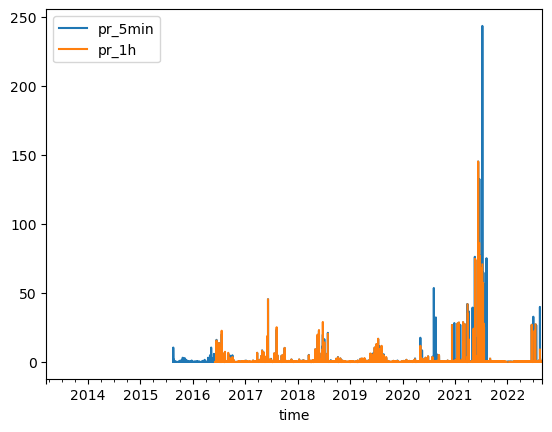

In [67]:
test_sum_skipna.plot(y=['pr_5min','pr_1h'])

<Axes: xlabel='time'>

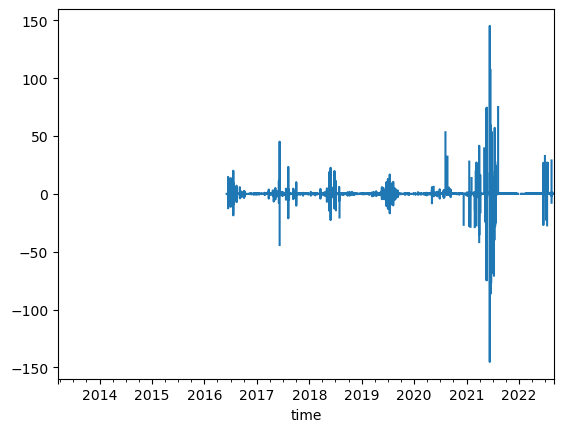

In [70]:
diff = test_sum_skipna['pr_5min']-test_sum_skipna['pr_1h']
diff.plot()

### Perform resampling

In [ ]:
sum_result_counts =  sum_df.resample('1h',on='time').count()
sum_result_counts.columns = sum_result_counts.columns.map(lambda x: "nobs_" + x + "_hourstd")
print(sum_result_counts)

In [ ]:
#instantaneous aggregation

instant_result =  instant_df.resample('1h',on='time').first()
print(instant_result)

In [ ]:
# concatenate qaqc flags within each hour
# takes 1.5 minutes to run!
qaqc_result = qaqc_df.resample('1h',on='time').apply(lambda x: ','.join(x.unique()))
print(qaqc_result)

In [ ]:
# keep the first value in each hour
constant_result =  constant_df.resample('1h',on='time').first()
print(constant_result)

In [ ]:

result_list = [sum_result,instant_result,constant_result,qaqc_result]
result = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
                                            how='outer'), result_list)

print(result)

In [ ]:
#alternative method for combinding the subsets that does not require a new module
result_merge = sum_result.merge(instant_result, on='time', how='outer').merge(constant_result, on='time', how='outer').merge(qaqc_result, on='time', how='outer')
print(result_merge)

## Final Function 

In [74]:
# Does not include log file and verbose statements, which are included in the utils scripts so that messages printed to log file

def hourly_standardization(df):
    """
    
    Resamples meteorological variables to hourly timestep according to standard conventions. 
    
    Rules
    ------
        1.) top of the hour: take the first value in each hour
            - standard convention for temperature, dewpoint, wind speed, direction, relative humidity, air pressure
        2.) summation across hour: sum observations within each hour
            - standard convention for precipitation and solar radiation
        3.) constant across the hour: take the first value in each hour
            - this applies to variables, like station name and location, that do not change within each hour

    Parameters
    ------
        df: pd.DataFrame 
            station dataset converted to dataframe through QAQC pipeline
        verbose: boolean
            input for printf() to print to log file - set in script initialization

    Returns
    -------
        if success:
            df [pd.DataFrame]
                QAQC dataframe with all columns resampled to one hour (column name retained) and
                columns with hourly observation counts for each variables
        if failure:
            None
    """

    print("Running: hourly_standardization", flush=True)

    ##### define the variables for each sub-dataframe #####

    # Variables that remain constant within each hour
    constant_vars = ["time","station", "lat", "lon", "elevation",
                    "anemometer_height_m","thermometer_height_m",
                    'sfcWind_method',
                    'pr_duration',
                    "hour","day","month","year","date"]

    # Aggregation across hour variables, standard meteorological convention: precipitation and solar radiation
    sum_vars = ["time",
                "pr","pr_localmid","pr_24h","pr_5min","pr_1h",
                "rsds"]

    # Top of the hour variables, standard meteorological convention: temperature, dewpoint temperature, pressure, humidity, winds
    instant_vars = ["time",
                "tas", "tdps","tdps_derived",
                "ps","psl","ps_altimeter","ps_derived",  
                "hurs",
                "sfcwind","sfcwind_dir"]
    
    # QAQC flags, which remain constants within each hour
    qaqc_vars = ["time","tas_qc", "tas_eraqc",
                "pr_5min_eraqc","pr_1h_eraqc","pr_5min_qc",'pr_eraqc','pr_depth_qc', 
                "ps_qc",'ps_altimeter_qc','ps_eraqc','ps_altimeter_eraqc', 
                'psl_qc','psl_eraqc',
                'tdps_qc','tdps_eraqc',
                'sfcWind_qc','sfcWind_dir_qc','sfcWind_eraqc','sfcWind_dir_eraqc'
                "elevation_eraqc", "qaqc_process"]
    
    # All variables, necessary for producing columns with hourly counts for each variable
    all_vars = constant_vars+sum_vars+instant_vars+qaqc_vars
    
    ##### Subset the dataframe according to rules
    constant_df = df[[col for col in constant_vars if col in df.columns]]

    qaqc_df = df[[col for col in qaqc_vars if col in df.columns]]
    qaqc_vars_subset = qaqc_df.columns.tolist()
    qaqc_vars_subset.remove("time")
    qaqc_df[qaqc_vars_subset] = qaqc_df[qaqc_vars_subset].astype(str)

    sum_df = df[[col for col in sum_vars if col in df.columns]]

    instant_df = df[[col for col in instant_vars if col in df.columns]]

    all_vars_df = df[[col for col in all_vars if col in df.columns]]
    
    ##### 
    
    try:        
        # if station does not report any variable, bypass
        if len(df.columns) == 0:
            print('Empty dataset - bypassing hourly aggregation', flush=True)
            return df
        else: 
            # Performing hourly aggregation
            constant_result =  constant_df.resample('1h',on='time').first()
            instant_result =  instant_df.resample('1h',on='time').first()
            sum_result =  sum_df.resample('1h',on='time').apply(lambda x: np.nan if x.isna().all() else x.sum(skipna=True))
            qaqc_result = qaqc_df.resample('1h',on='time').apply(lambda x: ','.join(x.unique())) # adding unique flags

            # # Generating variable counts per hour
            # all_vars_counts =  all_vars_df.resample('1h',on='time').count()
            # all_vars_counts.columns = all_vars_counts.columns.map(lambda x: "nobs_" + x + "_hourstd") # adding obs count per hour

            # # Aggregating and outputting reduced dataframe
            # result_list = [sum_result,instant_result,constant_result,qaqc_result,all_vars_counts]
            # result = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
            #                                 how='outer'), result_list)
            # return result

            # Aggregating and outputting reduced dataframe
            result_list = [sum_result,instant_result,constant_result,qaqc_result]
            result = reduce(lambda  left,right: pd.merge(left,right,on=['time'],
                                            how='outer'), result_list)
            return result
        
    except Exception as e:
        print("hourly_standardization failed with Exception: {0}".format(e), flush=True)
        return None

In [75]:
result = hourly_standardization(df)
print(result)

Running: hourly_standardization


/var/folders/gq/kbcbbl557b96fgdc4pc5k8mh0000gn/T/ipykernel_7347/413472883.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qaqc_df[qaqc_vars_subset] = qaqc_df[qaqc_vars_subset].astype(str)


                     pr_5min  pr_1h      tas    station     lat        lon  \
time                                                                         
2013-03-16 22:00:00      NaN    NaN  282.090  CRN_AGPC2  40.155 -103.14167   
2013-03-16 23:00:00      NaN    NaN  281.590  CRN_AGPC2  40.155 -103.14167   
2013-03-17 00:00:00      NaN    NaN  281.150  CRN_AGPC2  40.155 -103.14167   
2013-03-17 01:00:00      NaN    NaN  278.480  CRN_AGPC2  40.155 -103.14167   
2013-03-17 02:00:00      NaN    NaN  276.650  CRN_AGPC2  40.155 -103.14167   
...                      ...    ...      ...        ...     ...        ...   
2022-08-31 19:00:00      0.0    NaN  305.378  CRN_AGPC2  40.155 -103.14167   
2022-08-31 20:00:00      0.0    0.0  306.189  CRN_AGPC2  40.155 -103.14167   
2022-08-31 21:00:00      0.0    0.0  306.578  CRN_AGPC2  40.155 -103.14167   
2022-08-31 22:00:00      0.0    0.0  305.200  CRN_AGPC2  40.155 -103.14167   
2022-08-31 23:00:00      0.0    0.0  303.350  CRN_AGPC2  40.155 

## Code Sandbox

In [ ]:

# agg_funcs = {
#     col:'sum' if col in met_vars else continue
#     for col in df.columns
# }

#df_resampled = df.resample('D').agg(agg_funcs)

# result = df.resample('1h',on='time').add_funcs()
# result

In [ ]:
# try turning one particular column into a string
qaqc_df["tas_eraqc"] = qaqc_df["tas_eraqc"].astype(str)
# qaqc_df["tas_eraqc"].astype(str) #this does NOT work
print(qaqc_df['tas_eraqc'].apply(type))

In [ ]:
# Sample DataFrame
df = pd.DataFrame({
    'date': pd.date_range('2023-01-01', periods=10, freq='D'),
    'category': ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B'],
    'value': [10, 15, 12, 18, 14, 20, 16, 22, 18, 24]
})
df.set_index('date', inplace=True)

# Group by the variable and apply different resampling techniques
resampled_df = df.groupby('category').resample('W').agg({
    'value': {'A': 'mean', 'B': 'first'}
})

In [ ]:
    ##### identify which precipitation vars are reported  #####
    # all_pr_vars = [var for var in df.columns if 'pr' in var] # can be variable length depending if there is a raw qc var
    #pr_vars = [var for var in all_pr_vars if not any(True for item in vars_to_remove if item in var)] # remove all qc variables so they do not also run through: raw, eraqc, qaqc_process
    

In [ ]:
def nan_sum(x):
    output = np.nan if x.isna().all() else x.sum()
    return output

   # Use transform instead of agg

In [ ]:
def custom_resampler_sum(df,period,time_col):
    groups = df.resample(period,on=time_col)
    sums = [x[1].sum(skipna=False) for x in groups]
    return pd.DataFrame(sums, groups.indices)

In [ ]:
def custom_resample(x):
    if np.all(np.isnan(x)):
        return np.nan
    else:
        if x in sum_vars:
            return np.sum(x)
        if x in instant_vars:
            return np.first()
        if x in qaqc_vars:
            return np.apply(lambda x: ','.join(x.unique()))
        if x in constant_vars:
            return np.first()
        else:
            printf("custom resampling not successful", verbose=true, log_file=log_file, flush=True)